In [1]:
import os
import numpy as np
import pandas as pd
import time
import scanpy as sc
import torch

import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO)

import sys
sys.path.append('../../')
import scDualGN
sys.path.append('../')
import expri_helper

/jdfssz1/ST_HEALTH/P18Z10200N0124/AI/user/baiyong/anaconda3/envs/mytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load data
dat_path = expri_helper.get_path('Baron', dat_ls_file='../expri_data.json')
adata = sc.read_h5ad(dat_path)
adata.obs['celltype'] = adata.obs['cell_type1']

In [3]:
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.highly_variable_genes(adata, n_top_genes=2500)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
# sc.pp.scale(adata)

In [4]:

# acc 0.6655, nmi 0.8213, ari 0.6426, hs 0.9270, cs 0.7372, purity: 0.9732 alpha=0.001
# acc 0.7613, nmi 0.8537, ari 0.8024, hs 0.9258, cs 0.7921, purity: 0.9709 alpha=0.05

# start = time.time()
# scdualgn_model = scDualGN.scDualGN(adata, n_z=32,device='cuda:2', verbosity=True, batch_size=1024*2).pretrain(alpha=0.05, beta=20, gamma=4)
# scdualgn_model.cluster(n_cluster=14,eta=1, nu=0.1, n_epochs=30)
# end = time.time()

# print('running time = {}'.format(end-start))

# lr, alpha, gamma, nu = 0.001, 0.5, 4, 0.01
# acc 0.7009, nmi 0.7863, ari 0.6275, hs 0.8596, cs 0.7246, purity: 0.9331

# lr, alpha, gamma, nu = 0.001, 0.5, 2, 0.01
# acc 0.8158, nmi 0.8465, ari 0.7890, hs 0.9073, cs 0.7933, purity: 0.9627

# lr, alpha, gamma, nu = 0.001, 0.5, 4, 0.01
lr, alpha, gamma, nu = 0.01, 0.01, 4, 0.01
# acc 0.7294, nmi 0.7960, ari 0.7599, hs 0.8487, cs 0.7494, purity: 0.9262
print('=====================================')
print('lr:{}, alpha:{}, gamma:{}, nu:{}'.format(lr, alpha, gamma, nu))
start = time.time()
torch.cuda.empty_cache()
scdualgn_model = scDualGN.scDualGN(adata, n_z=32,device='cuda:3', batch_size=1024*2, verbosity=True, lr=lr).pretrain(alpha=alpha, beta=1, gamma=gamma)
scdualgn_model.cluster(n_cluster=14, eta=1, nu=nu, n_epochs=32)

end = time.time()
print('running time = {}'.format(end-start))


INFO:scDualGN.run:dual-VAE pretrain start...


lr:0.01, alpha:0.01, gamma:4, nu:0.01


INFO:scDualGN.run:Epoch 1/100,Overall loss:2796.1136,MSE:2074.1903,MSE1:180.0574,KL: 169.3891
INFO:scDualGN.run:Epoch 2/100,Overall loss:1623.0799,MSE:1617.2878,MSE1:0.6359,KL: 324.8334
INFO:scDualGN.run:Epoch 3/100,Overall loss:1582.7430,MSE:1577.6234,MSE1:0.4093,KL: 348.2448
INFO:scDualGN.run:Epoch 4/100,Overall loss:1559.0302,MSE:1553.9778,MSE1:0.4177,KL: 338.1341
INFO:scDualGN.run:Epoch 5/100,Overall loss:1552.7461,MSE:1548.0418,MSE1:0.3590,KL: 326.8430
INFO:scDualGN.run:Epoch 6/100,Overall loss:1537.5060,MSE:1532.9768,MSE1:0.3459,KL: 314.5616
INFO:scDualGN.run:Epoch 7/100,Overall loss:1525.2152,MSE:1520.7467,MSE1:0.3508,KL: 306.5418
INFO:scDualGN.run:Epoch 8/100,Overall loss:1514.9701,MSE:1510.5415,MSE1:0.3536,KL: 301.4069
INFO:scDualGN.run:Epoch 9/100,Overall loss:1507.9436,MSE:1503.5398,MSE1:0.3546,KL: 298.5500
INFO:scDualGN.run:Epoch 10/100,Overall loss:1505.2131,MSE:1500.8327,MSE1:0.3528,KL: 296.9224
INFO:scDualGN.run:Epoch 11/100,Overall loss:1530.2137,MSE:1525.8955,MSE1:0.36

acc 0.7294, nmi 0.7960, ari 0.7599, hs 0.8487, cs 0.7494, purity: 0.9262
running time = 85.12876033782959


In [5]:
adata.obs['celltype_scDualGN']=scdualgn_model.y_pred_label
adata.obs['celltype_scDualGN'] = adata.obs['celltype_scDualGN'].astype('category')
adata.obs['celltype'] = adata.obs['celltype'].astype('category')
adata.obsm['X_z']=scdualgn_model.z

sc.pp.neighbors(adata,n_neighbors=20,use_rep="X_z") 
sc.tl.umap(adata)


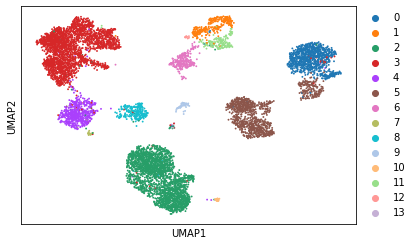

In [6]:
sc.pl.umap(adata, color=['celltype'],title='')

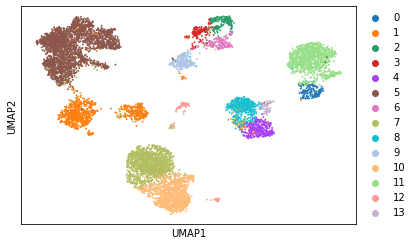

In [7]:
sc.pl.umap(adata, color=['celltype_scDualGN'],title='')